In [1]:
import copy
import csv
import cv2
import glob
import os
import shutil
import time
from collections import Counter
from datetime import timedelta
import shortuuid

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from torchvision import models, transforms

def ann_file(data_dir):
    return os.path.join(data_dir, "TrainAnnotations.csv")


TRAIN_DATA_DIR = "data/TrainData-C2"
TRAIN_DATA_ANN_FILE = ann_file(TRAIN_DATA_DIR)

TRAIN_SPLIT_DATA_DIR           = "data/train/split"
TRAIN_SPLIT_ANN_FILE           = ann_file(TRAIN_SPLIT_DATA_DIR)
TRAIN_SPLIT_AUGMENTED_DATA_DIR = "data/train/augmented"
TRAIN_SPLIT_AUGMENTED_ANN_FILE = ann_file(TRAIN_SPLIT_AUGMENTED_DATA_DIR)
TRAIN_SPLIT_PATCHES_DATA_DIR   = "data/train/patches"
TRAIN_SPLIT_PATCHES_ANN_FILE   = ann_file(TRAIN_SPLIT_PATCHES_DATA_DIR)

TRAIN_ALL_AUGMENTED_DATA_DIR   = "data/train-all/augmented"
TRAIN_ALL_AUGMENTED_ANN_FILE   = ann_file(TRAIN_ALL_AUGMENTED_DATA_DIR)
TRAIN_ALL_PATCHES_DATA_DIR     = "data/train-all/patches"
TRAIN_ALL_PATCHES_ANN_FILE     = ann_file(TRAIN_ALL_PATCHES_DATA_DIR)

VAL_SPLIT_DATA_DIR         = "data/val/split"
VAL_SPLIT_ANN_FILE         = ann_file(VAL_SPLIT_DATA_DIR)
VAL_SPLIT_PATCHES_DATA_DIR = "data/val/patches"
VAL_SPLIT_PATCHES_ANN_FILE = ann_file(VAL_SPLIT_PATCHES_DATA_DIR)

TEST_DATA_DIR         = "data/TestData/"
TEST_PATCHES_DATA_DIR = "data/test/patches"


## Enable GPU if available

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Split data
Generate random, stratified 80/20 split for training and validation sets

In [3]:
if (os.path.exists(TRAIN_SPLIT_DATA_DIR) or os.path.exists(VAL_SPLIT_DATA_DIR)):
    print("Data directories for splits already exist. Skipping")
else:
    # Generate 80/20 split

    print("Reading {} annotations...".format(TRAIN_DATA_ANN_FILE))
    ann_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})

    print("Splitting data into training and validation sets...")
    train_df, val_df = train_test_split(ann_df,
                                        train_size=0.80,
                                        random_state=138,
                                        shuffle=True,
                                        stratify=ann_df[['annotation']].to_numpy(dtype=np.int32).flatten())

    os.makedirs(TRAIN_SPLIT_DATA_DIR)
    os.makedirs(VAL_SPLIT_DATA_DIR)
    
    print("Copying files for training split...")
    for _, row in train_df.iterrows():
        filename = row['file_name']
        src = os.path.join(TRAIN_DATA_DIR, filename)
        dest = os.path.join(TRAIN_SPLIT_DATA_DIR, filename)
        shutil.copyfile(src, dest)
        
    print("Generating training split annotations...")
    train_df.sort_values('file_name').to_csv(TRAIN_SPLIT_ANN_FILE, index=False)
        
    print("Copying files for validation split...")
    for _, row in val_df.iterrows():
        filename = row['file_name']
        src = os.path.join(TRAIN_DATA_DIR, filename)
        dest = os.path.join(VAL_SPLIT_DATA_DIR, filename)
        shutil.copyfile(src, dest)
        
    print("Generating validation split annotations...")
    val_df.sort_values('file_name').to_csv(VAL_SPLIT_ANN_FILE, index=False)
        
    print("Done.")

Data directories for splits already exist. Skipping


## Augment data
Because the training dataset is unbalanced, augment the training data set by generating
new images for the lower numbered samples.

In [4]:
DESIRED_CLASS_SAMPLE_COUNT = 400
RANDOM_STATE = 13

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
PATCH_ROWS = 5
PATCH_COLUMNS = 5


def is_image_file(filename):
    return filename.endswith(IMG_EXTENSIONS)


def augment_data(src_dir, src_ann_file, dest_dir, dest_ann_file, class_sample_count=500):
    os.makedirs(dest_dir)

    ann_df = pd.read_csv(src_ann_file, dtype={'file_name': 'object', 'annotation': 'category'}) 
    new_samples = {}
    
    for i in range(5):
        class_df = ann_df.query("annotation == '{}'".format(i))
        num_class_samples = class_df.shape[0]
        num_to_create = class_sample_count - num_class_samples
            
        print("Creating {} images for class {}".format(num_to_create, i))
        samples = class_df.sample(n=num_to_create, replace=True, random_state=RANDOM_STATE)
    
        for idx, row in samples.iterrows():
            new_filename = row['file_name'].split('.')[0] + "_" + shortuuid.uuid() + ".png"
    
            # Apply transformations to each randomly selected sample
            img = Image.open(src_dir + "/" + row['file_name'])
            image_transforms = transforms.Compose([
                transforms.RandomAffine(degrees=20, translate=(0.2, 0.2)),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                transforms.RandomResizedCrop((480, 640), scale=(1.0, 1.2)),
            ])
            transformed_img = image_transforms(img)
            transformed_img.save(os.path.join(dest_dir, new_filename))
    
            new_samples[new_filename] = row['annotation']
    
    # Add to new dataframe
    balanced_df = pd.read_csv(src_ann_file, dtype={'file_name': 'object', 'annotation': 'category'})
    balanced_df = balanced_df.append(pd.DataFrame.from_records([(k, v) for k, v in new_samples.items()],
                                                 columns=['file_name', 'annotation']))
    
    # Write new annotations
    balanced_df.sort_values('file_name').to_csv(dest_ann_file, index=False)
    
    # Copy images from training data split
    for file in glob.glob(src_dir + "/*"):
        if is_image_file(file):
            shutil.copy(file, os.path.join(dest_dir, os.path.basename(file)))


def generate_image_patches(img, rows, cols):
    """
    Generates a list of in-memory image overlapping patches
    
    Args:
        rows - number of rows of patchs to cover the height of the image
        cols - number of colums of patches to cover the width of the image
    """
    patches = []
    sizeX = img.shape[1]
    sizeY = img.shape[0]
    
    patch_sizeX = 224
    patch_sizeY = 224
    patch_relative_centerX = 112
    patch_relative_centerY = 112

    for i in range(0,rows):
        for j in range(0, cols):
            center = (patch_relative_centerX + (sizeX - patch_sizeX)/(rows - 1)*i, 
                      patch_relative_centerY + (sizeY - patch_sizeY)/(cols - 1)*j)
            patches.append(cv2.getRectSubPix(img, (patch_sizeX, patch_sizeY), center))
            
    return patches


def generate_patch_files(in_dir, out_dir, rows, cols):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    images = [f for f in os.listdir(in_dir) if os.path.isfile(os.path.join(in_dir, f)) and is_image_file(f)]   
    for im in images:
        img = cv2.imread(os.path.join(in_dir, im))
        patches = generate_image_patches(img, rows, cols)
        
        for i in range(0,rows):
            for j in range(0, cols):
                patch = patches[i*rows + j]
                patch_name = im.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                cv2.imwrite(out_dir + '/' + patch_name, patch)


def generate_patch_annotations_df(df, rows, cols):
    patches_ann = {}
    
    for ind in df.index: 
        file_name = df['file_name'][ind]
        annotation = df['annotation'][ind]
        
        for i in range(0, rows):
            for j in range(0, cols):
                patch_name = file_name.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                patches_ann[patch_name] = annotation
    
    return pd.DataFrame.from_records([(k, v) for k, v in patches_ann.items()], 
                                     columns=['file_name', 'annotation'])


### Run data augmentation

Perform the data augmentation on the training data set split to balance the class samples.

In [5]:
if os.path.exists(TRAIN_SPLIT_AUGMENTED_DATA_DIR):
    print("Augmented SPLIT training data already exists. Skipping.")
else:
    print("Balancing class samples for SPLIT training data...")
    augment_data(TRAIN_SPLIT_DATA_DIR,
                 TRAIN_SPLIT_ANN_FILE,
                 TRAIN_SPLIT_AUGMENTED_DATA_DIR,
                 TRAIN_SPLIT_AUGMENTED_ANN_FILE,
                 class_sample_count=400)    
    print("Done.")

if os.path.exists(TRAIN_ALL_AUGMENTED_DATA_DIR):
    print("Augmented ALL training data already exists. Skipping.")
else:
    print("Balancing class samples for ALL training data...")
    augment_data(TRAIN_DATA_DIR,
                 TRAIN_DATA_ANN_FILE,
                 TRAIN_ALL_AUGMENTED_DATA_DIR,
                 TRAIN_ALL_AUGMENTED_ANN_FILE,
                 class_sample_count=500)
    print("Done.")

Augmented SPLIT training data already exists. Skipping.
Augmented ALL training data already exists. Skipping.


## Generate Patches

In [6]:
# SPLIT train patches
if os.path.exists(TRAIN_SPLIT_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TRAIN_SPLIT_PATCHES_DATA_DIR))
else:
    print("Generating SPLIT training data patches...")
    generate_patch_files(TRAIN_SPLIT_AUGMENTED_DATA_DIR, TRAIN_SPLIT_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating SPLIT training patch data annotations...")
    image_df = pd.read_csv(TRAIN_SPLIT_AUGMENTED_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(TRAIN_SPLIT_PATCHES_ANN_FILE, index=False)
    
# SPLIT val patches
if os.path.exists(VAL_SPLIT_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(VAL_SPLIT_PATCHES_DATA_DIR))
else:
    print("Generating SPLIT validation data patches...")
    generate_patch_files(VAL_SPLIT_DATA_DIR, VAL_SPLIT_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating SPLIT validation patch data annotations...")
    image_df = pd.read_csv(VAL_SPLIT_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(VAL_SPLIT_PATCHES_ANN_FILE, index=False)

# test patches
if os.path.exists(TEST_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TEST_PATCHES_DATA_DIR))
else:
    print("Generating test data patches...")
    generate_patch_files(TEST_DATA_DIR, TEST_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)
    
# ALL train patches
if os.path.exists(TRAIN_ALL_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TRAIN_ALL_PATCHES_DATA_DIR))
else:
    print("Generating ALL train data patches...")
    generate_patch_files(TRAIN_ALL_AUGMENTED_DATA_DIR, TRAIN_ALL_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating ALL training patch data annotations...")
    image_df = pd.read_csv(TRAIN_ALL_AUGMENTED_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(TRAIN_ALL_PATCHES_ANN_FILE, index=False)

print("Done.")

data/train/patches exists. Skipping.
data/val/patches exists. Skipping.
data/test/patches exists. Skipping.
data/train-all/patches exists. Skipping.
Done.


## Datasets

Given a directory of images and a CSV file of annotations, this defines a PyTorch Dataset which will load an image from disk and apply all configure transformations and return a tuple containing the image and label.


In [7]:
class SoybeanDataset(torch.utils.data.dataset.Dataset):
    def __init__(self, data_path, ann_df, transforms=None):
        """
        Args:
            data_path (string): path to images
            ann_df (string): pandas data frame containing file names and annotations
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data_path = data_path
        
        self.data = ann_df
        self.labels = np.asarray(self.data.iloc[:, 1])
        
        self.transforms = transforms

    def __getitem__(self, index):
        #print('index:', index)
        image_label = int(self.labels[index])
        img_path = os.path.join(self.data_path, self.data.file_name[index])

        img = Image.open(img_path)
        
        # Transform image
        if self.transforms is not None:
            img = self.transforms(img)
            
        # Return image and the label
        return img, image_label

    def __len__(self):
        return self.data.shape[0]


class SoybeanTestDatasetFolder(torch.utils.data.IterableDataset):
    def __init__(self, data_path, transforms=None):
        """
        Args:
            data_path (string): path to images
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data_path = data_path
        self.transforms = transforms
        
        self.images = []
        
        for root, _, fnames in sorted(os.walk(data_path, followlinks=True)):
            for fname in sorted(fnames):
                path = fname
                if is_image_file(path):
                    self.images.append(path)

                                       
    def image_gen(self):
        for i in self.images:
            img_path = os.path.join(self.data_path, i)
            img = Image.open(img_path)
        
            # Transform image
            if self.transforms is not None:
                img = self.transforms(img)
                
            yield img
            

    def __iter__(self):
        return iter(self.image_gen())

    
    def __len__(self):
        return len(self.images)
    


class SoybeanDataGroup():
    def __init__(self, class_weights, 
                 train_dataloader,
                 val_dataloader=None,
                 test_dataloader=None):
        self.class_weights = class_weights
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader


def compute_class_weights(df, y_col):
    """
    Returns a list of class labels to 'balanced' weights based on the
    frequency of the weights across the labels in the specified dataframe
    """
    y = df[[y_col]].to_numpy(dtype=np.int32).flatten()
    weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
    return torch.tensor(weights, dtype=torch.float32).to(device)
    


### Common image transformations
These images transformations will apply to both train and validation data.

In [8]:
class SamplewiseCenterNormalize(object):

    def __init__(self):
        pass
    
    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.

        Returns:
            Tensor: Normalized Tensor image.
        """
        
        return torch.div(torch.add(tensor, torch.mul(torch.mean(tensor), -1)), torch.std(tensor) + 1e-6)
        

    def __repr__(self):
        return self.__class__.__name__



DATA_TRANSFORMS = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.RandomAffine(degrees=20, translate=(0.2, 0.2)),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), shear=10, scale=(1.0, 1.2)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    #transforms.RandomCrop(size=(480,640)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # SamplewiseCenterNormalize()

    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

TEST_DATA_TRANSFORMS = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # SamplewiseCenterNormalize()
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

### Train 0.80/Val 0.20 Split

In [9]:
def train_val_split_group(class_weights=None):
    
    print("Reading annotations...")
    train_ann_df = pd.read_csv(TRAIN_SPLIT_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    val_ann_df   = pd.read_csv(VAL_SPLIT_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    if class_weights is None:
        print("Computing class weights...")
        class_weights = compute_class_weights(train_ann_df, 'annotation')
        print(class_weights)
    else:
        print("Using class weights:", class_weights)
        
    train_dataset = SoybeanDataset(TRAIN_SPLIT_PATCHES_DATA_DIR, train_ann_df, transforms=DATA_TRANSFORMS)
    val_dataset = SoybeanDataset(VAL_SPLIT_PATCHES_DATA_DIR, val_ann_df, transforms=TEST_DATA_TRANSFORMS)
    test_dataset  = SoybeanTestDatasetFolder(TEST_PATCHES_DATA_DIR, transforms=TEST_DATA_TRANSFORMS)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   pin_memory=True, 
                                                   num_workers=16)
    val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                                 batch_size=BATCH_SIZE,
                                                 pin_memory=True,
                                                 num_workers=16)
    test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=BATCH_SIZE,
                                                  pin_memory=True,
                                                  num_workers=0)
    
    return SoybeanDataGroup(class_weights, train_dataloader, val_dataloader, test_dataloader)


### Train 100%

Train with all the data in the `TrainData-C2` dataset 

In [10]:
def all_train_data_group(class_weights=None):
    print("Reading annotations...")
    ann_df = pd.read_csv(TRAIN_DATA_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    if class_weights is None:
        print("Computing class weights...")
        class_weights = compute_class_weights(ann_df, 'annotation')
        print(class_weights)
    else:
        print("Using class weights:", class_weights)

    train_dataset = SoybeanDataset(TRAIN_DATA_PATCHES_DIR, ann_df, transforms=DATA_TRANSFORMS)
    test_dataset  = SoybeanTestDatasetFolder(TEST_DATA_PATCHES_DIR, transforms=TEST_DATA_TRANSFORMS)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   pin_memory=True, 
                                                   num_workers=16)
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=BATCH_SIZE,
                                                  pin_memory=True,
                                                  num_workers=0)
    
    return SoybeanDataGroup(class_weights, train_dataloader, None, test_dataloader)

## Model

This model is based on the VGG16 network with custom classifier layers 
with the feature layers initialized with weights based on the ImageNet data. 

The number of neurons and dropout rates in the classifier layers are parameterized.

In [11]:
def get_model(n1, n2, dropout, batch_normalization=False):
    if batch_normalization:
        model = models.vgg16_bn(pretrained=True)
    else:
        model = models.vgg16(pretrained=True) 

    # Freeze training for all layers
    for param in model.features.parameters():
        param.requires_grad = False

    model.avgpool = nn.AdaptiveAvgPool2d((1,1))
    
    # Replace the VGG16 classifier with a custom classifier for soybean wilting 
    model.classifier = nn.Sequential(
        nn.Linear(512 * 1 * 1, n1, bias=True),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(n1, n2, bias=True),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(n2, 5, bias=True)
    )
    
    return model

## Training loop
For training and validation, this trains a model across a configured number of epochs and outputs the training and validation loss and accuracy for each epoch.

In [12]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=25):
    """
    Trains the specified neural network model
    
    Args:
        model:         - neural network model to train
        criterion:     - loss function
        optimizer:     - gradient descent optimization algorithm
        dataloaders:   - dict of DataLoaders for training and validation data
        num_epochs:    - number of epochs to train model
    Returns:
        model   - trained model with weights from the epoch with the best validation accuracy
        history - dict of training and validation loss and accuracy for all epochs
    """
    since = time.time()
    
    # summary(model, input_size=(3, 224, 224))

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train': {'loss': [], 'acc': []}}
    phases = ['train']
    if ('val' in dataloaders and dataloaders['val'] is not None):
        phases += ['val']
        history['val'] = {'loss': [], 'acc': []}
    
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and optionally, a validation phase
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            phase_start = time.time()

            sample_count = 0
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:               
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        nn.utils.clip_grad_norm_(model.parameters(), 1)
                        nn.utils.clip_grad_value_(model.parameters(), 0.5)
                        optimizer.step()

                # statistics
                sample_count += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += preds.eq(labels.data.view_as(preds)).cpu().sum()
            
            print('Num samples', sample_count)
            
            epoch_loss = running_loss / sample_count
            epoch_acc = running_corrects.double() / sample_count
            
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc)
            
            phase_end = time.time()
            phase_elapsed = phase_end - phase_start

            print('{} {} loss: {:.4f} accuracy: {:.4f}'.format(
                phase, str(timedelta(seconds=phase_elapsed)), epoch_loss, epoch_acc))

            # deep copy the model
            if ('val' not in phases or phase == 'val') and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_end = time.time()
        epoch_elapsed = epoch_end - epoch_start
        print('Elapsed time: {}'.format(str(timedelta(seconds=epoch_elapsed))))
        
        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

## Train models

In [40]:
BATCH_SIZE = 32

def get_sample_count(dataset, sampler):
    if (sampler is not None):
        return len(sampler)
    elif (dataset is not None):
        return len(dataset)
    else:
        return None
    

def train(model, group, num_epochs=20):
    criterion = nn.CrossEntropyLoss(weight=group.class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-07)
    
    dataloaders = {
        'train': group.train_dataloader,
        'val': group.val_dataloader
    }
 
    model_trained, history = train_model(model, criterion, optimizer, dataloaders, num_epochs)
    
    
    return model_trained, history


def get_all_labels(loader):
    all_labels = torch.tensor([], dtype=torch.long)
    for batch in loader:
        _, labels = batch
        all_labels = torch.cat((all_labels, labels), dim=0)
    return all_labels


def get_all_whole_image_labels(patch_labels):
    patch_label_groups = np.split(patch_labels, int(len(patch_labels)/(PATCH_ROWS * PATCH_COLUMNS)))
    image_labels = np.array(list(map(lambda x: x[0], patch_label_groups)))
    return image_labels


def get_all_whole_image_predictions(patch_preds):
    patch_pred_groups = np.split(patch_preds, int(len(patch_preds)/(PATCH_ROWS * PATCH_COLUMNS)))
    image_preds = np.array(list(map(lambda x: stats.mode(x).mode[0], patch_pred_groups)))
    return image_preds


def plot_metrics(model, history, train_dataloader, val_dataloader=None):
    
    print()
    print('Metrics')
    print('-' * 10)
    
    # Create count of the number of epochs
    epoch_count = range(1, len(history['train']['loss']) + 1)

    # Visualize loss history
    plt.plot(epoch_count, history['train']['loss'], 'g-')
    loss_legend = ['Training Loss']
    
    if ('val' in history and history['val'] is not None):
        plt.plot(epoch_count, history['val']['loss'], 'b-')
        loss_legend += ['Validation Loss']
        
    plt.legend(loss_legend)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Visualize accuracy history
    plt.plot(epoch_count, history['train']['acc'], 'g-')
    acc_legend = ['Training Accuracy']
    
    if ('val' in history and history['val'] is not None):
        plt.plot(epoch_count, history['val']['acc'], 'b-')
        acc_legend += ['Validation Accuracy']
    
    plt.legend(acc_legend)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
    # Training confusion matrix
    train_patch_labels = get_all_labels(train_dataloader).cpu().numpy()
    train_patch_predictions = predict(model, train_dataloader).cpu().numpy()
    
    print("Training Confusion Matrix of Patches")
    print("-" * 30)
    print_confusion_matrix(train_patch_labels, train_patch_predictions)
    
    print("Training Confusion Matrix of Whole Images")
    print("-" * 30)
    print_confusion_matrix(get_all_whole_image_labels(train_patch_labels),
                           get_all_whole_image_predictions(train_patch_predictions))
    
    # Validation confusion matrix
    if val_dataloader is not None:
        val_patch_labels = get_all_labels(val_dataloader).cpu().numpy()
        val_patch_predictions = predict(model, val_dataloader).cpu().numpy()
        
        print("Validation Confusion Matrix of Patches")
        print("-" * 30)
        print_confusion_matrix(val_patch_labels, val_patch_predictions)
        
        print("Validation Confusion Matrix of Whole Images")
        print("-" * 30)
        print_confusion_matrix(get_all_whole_image_labels(val_patch_labels),
                               get_all_whole_image_predictions(val_patch_predictions))


def train_and_test(model, group, num_epochs=60):
    model_trained, history = train(model, group, num_epochs)
    
    # Plot history metrics
    plot_metrics(model_trained, history, group.train_dataloader, group.val_dataloader)
    
    # Classify test data
    return predict(model_trained, group.test_dataloader)


def predict(model, dataloader):
    predictions = torch.tensor([], dtype=torch.long).to(device)
    
    with torch.no_grad():
        for data in dataloader:
            if (type(data) is list):
                images = data[0].to(device)
            else:
                images = data.to(device)
            model.eval()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions = torch.cat((predictions, predicted))

    return predictions


def predict_whole_images(patch_predictions, rows, columns, csvfile):
    y_hat_test = patch_predictions.cpu().numpy()
    y_hat_patch_groups = np.split(y_hat_test, int(len(y_hat_test)/(rows * columns)))
    y_hat_whole_images = list(map(lambda x: stats.mode(x).mode[0], y_hat_patch_groups))

    for k, v in sorted(Counter(y_hat_whole_images).items()): 
        print(str(k) + ': '+ str(v))    

    one_hots = [np.zeros((5,1)) for pred in y_hat_whole_images]
    for i in range(len(one_hots)):
        pred = y_hat_whole_images[i]  # the index of the one-hot encoding
        one_hots[i][pred] = 1
    with open(csvfile, 'w') as predictions_file:
        writer = csv.writer(predictions_file)
        for pred in one_hots:
            pred = np.array(pred, dtype=int)
            writer.writerow(pred.T.tolist()[0])
    print('Finished generating predictions to', csvfile)


def print_confusion_matrix(y, y_hat):
    confusion_matrix = np.zeros((5, 5))
    labels = [0, 1, 2, 3, 4]
    for i in range(len(labels)):
        for j in range(len(labels)):
            ground_truth = y==labels[i]
            prediction = y_hat==labels[j]
            confusion_matrix[i, j] = sum(np.bitwise_and(ground_truth, prediction))
    df = pd.DataFrame(confusion_matrix, dtype=int)
    display(df)

### Train and Test - 80/20 Split

In [ ]:
model = get_model(1024, 128, 0.5).to(device)
y_hat_test = train_and_test(model, train_val_split_group(), num_epochs=1)
predictions_file = "predict_c2_g1_" + shortuuid.uuid()
print('predictions file:', predictions_file)
predict_whole_images(y_hat_test, 5, 5, predictions_file)

### Train and Test - All Train Data


In [ ]:
model = get_model(1024, 128, 0.1).to(device)
y_hat_test = train_and_test(model, group_3())
predict_whole_images(y_hat_test, 5, 5, 'predictions_c2_g3.csv')


## Hyperparameter Optimization
The following hyperparameters can be tuned:
1. `n1` - Number of neurons in the first classifier dense layer
2. `n2` - Number of neurons in the second classifier dense layer
3. `d` - Dropout rate after classifier dense layers
4. class weights - `[1,1,1,1,1]` (default) or `[1,1,5,5,1]`
5. batch normalization - `no` or `yes`



In [22]:
def run_trial(name, model, class_weights=None, num_epochs=60):
    y_hat_test = train_and_test(model, train_val_split_group(class_weights), num_epochs)
    predictions_file = "predict_c2_{}_{}.csv".format(name, shortuuid.uuid())
    print('predictions file:', predictions_file)
    predict_whole_images(y_hat_test, PATCH_ROWS, PATCH_COLUMNS, predictions_file)
    return y_hat_test

#### H1: 1024-128-5

* DNN Structure: 1024-128-5
* Dropout: 0.5
* Class weights: [1,1,1,1,1]
* Batch normalization: no


Reading annotations...
Computing class weights...
tensor([1., 1., 1., 1., 1.], device='cuda:0')
Epoch 0/59
----------
Num samples 50000
train 0:01:31.073406 loss: 1.3310 accuracy: 0.4846
Num samples 6375
val 0:00:11.875673 loss: 9.5041 accuracy: 0.3812
Elapsed time: 0:01:42.951981

Epoch 1/59
----------
Num samples 50000
train 0:01:31.344711 loss: 1.2085 accuracy: 0.5304
Num samples 6375
val 0:00:11.946585 loss: 9.0814 accuracy: 0.3853
Elapsed time: 0:01:43.293341

Epoch 2/59
----------
Num samples 50000
train 0:01:31.705893 loss: 1.1496 accuracy: 0.5561
Num samples 6375
val 0:00:11.943962 loss: 6.9452 accuracy: 0.3914
Elapsed time: 0:01:43.652851

Epoch 3/59
----------
Num samples 50000
train 0:01:31.741663 loss: 1.1211 accuracy: 0.5760
Num samples 6375
val 0:00:11.948731 loss: 7.4843 accuracy: 0.3933
Elapsed time: 0:01:43.693568

Epoch 4/59
----------
Num samples 50000
train 0:01:31.999556 loss: 1.0872 accuracy: 0.5864
Num samples 6375
val 0:00:12.013493 loss: 7.7102 accuracy: 0.3947

Num samples 50000
train 0:01:36.636716 loss: 0.9325 accuracy: 0.6565
Num samples 6375
val 0:00:12.769505 loss: 4.0996 accuracy: 0.4050
Elapsed time: 0:01:49.407048

Epoch 44/59
----------
Num samples 50000
train 0:01:34.911863 loss: 0.9394 accuracy: 0.6581
Num samples 6375
val 0:00:12.681767 loss: 4.1986 accuracy: 0.4207
Elapsed time: 0:01:47.596984

Epoch 45/59
----------
Num samples 50000
train 0:01:36.778549 loss: 0.9466 accuracy: 0.6568
Num samples 6375
val 0:00:12.659348 loss: 4.2770 accuracy: 0.4042
Elapsed time: 0:01:49.438734

Epoch 46/59
----------
Num samples 50000
train 0:01:36.529323 loss: 0.9278 accuracy: 0.6610
Num samples 6375
val 0:00:12.647430 loss: 3.9769 accuracy: 0.4193
Elapsed time: 0:01:49.177633

Epoch 47/59
----------
Num samples 50000
train 0:01:33.417172 loss: 0.9397 accuracy: 0.6551
Num samples 6375
val 0:00:12.472143 loss: 3.9572 accuracy: 0.4107
Elapsed time: 0:01:45.890189

Epoch 48/59
----------
Num samples 50000
train 0:01:36.468306 loss: 0.9305 accuracy

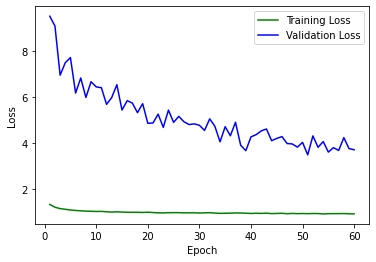

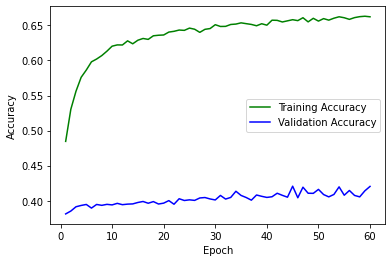

Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,20,9926,4,14,36
1,1,9761,1,16,221
2,3,9010,57,87,843
3,3,6153,3,444,3397
4,0,728,1,21,9250


Training Confusion Matrix of Whole Images
------------------------------


TypeError: 'numpy.bool_' object is not iterable

In [38]:
model = get_model(1024, 128, 0.5).to(device)
run_trial("h1", model)

In [42]:
group = train_val_split_group()
train_dataloader = group.train_dataloader
val_dataloader = group.val_dataloader

# Training confusion matrix
train_patch_labels = get_all_labels(train_dataloader).cpu().numpy()
train_patch_predictions = predict(model, train_dataloader).cpu().numpy()

#print("Training Confusion Matrix of Patches")
#print("-" * 30)
#print_confusion_matrix(train_patch_labels, train_patch_predictions)

print("Training Confusion Matrix of Whole Images")
print("-" * 30)
print_confusion_matrix(get_all_whole_image_labels(train_patch_labels),
                       get_all_whole_image_predictions(train_patch_predictions))

# Validation confusion matrix
if val_dataloader is not None:
    val_patch_labels = get_all_labels(val_dataloader).cpu().numpy()
    val_patch_predictions = predict(model, val_dataloader).cpu().numpy()

    print("Validation Confusion Matrix of Patches")
    print("-" * 30)
    print_confusion_matrix(val_patch_labels, val_patch_predictions)

    print("Validation Confusion Matrix of Whole Images")
    print("-" * 30)
    print_confusion_matrix(get_all_whole_image_labels(val_patch_labels),
                           get_all_whole_image_predictions(val_patch_predictions))

Reading annotations...
Computing class weights...
tensor([1., 1., 1., 1., 1.], device='cuda:0')
Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,0,400,0,0,0
1,0,400,0,0,0
2,0,381,2,0,17
3,0,294,0,0,106
4,0,9,0,0,391


Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,13,2431,0,3,3
1,2,1630,1,3,14
2,5,564,0,37,44
3,27,300,0,119,204
4,1,41,0,13,920


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,0,98,0,0,0
1,0,66,0,0,0
2,0,24,0,1,1
3,0,14,0,4,8
4,0,0,0,0,39


#### H2: 2048-256-5

* DNN Structure: 2048-256-5
* Dropout: 0.5
* Class weights: [1,1,1,1,1]
* Batch normalization: no


Reading annotations...
Computing class weights...
tensor([1., 1., 1., 1., 1.], device='cuda:0')
Epoch 0/59
----------
Num samples 50000
train 0:01:33.446317 loss: 1.3905 accuracy: 0.4789
Num samples 6375
val 0:00:12.701587 loss: 9.2033 accuracy: 0.3824
Elapsed time: 0:01:46.150866

Epoch 1/59
----------
Num samples 50000
train 0:01:36.409611 loss: 1.2681 accuracy: 0.5193
Num samples 6375
val 0:00:12.719525 loss: 8.2036 accuracy: 0.3848
Elapsed time: 0:01:49.132174

Epoch 2/59
----------
Num samples 50000
train 0:01:35.383533 loss: 1.1811 accuracy: 0.5454
Num samples 6375
val 0:00:12.390535 loss: 9.0899 accuracy: 0.3915
Elapsed time: 0:01:47.777464

Epoch 3/59
----------
Num samples 50000
train 0:01:34.742720 loss: 1.1304 accuracy: 0.5666
Num samples 6375
val 0:00:12.707570 loss: 8.9100 accuracy: 0.3962
Elapsed time: 0:01:47.453331

Epoch 4/59
----------
Num samples 50000
train 0:01:34.798719 loss: 1.1193 accuracy: 0.5775
Num samples 6375
val 0:00:12.342146 loss: 8.5697 accuracy: 0.3942

Num samples 50000
train 0:01:32.168537 loss: 0.9234 accuracy: 0.6613
Num samples 6375
val 0:00:12.006393 loss: 4.0248 accuracy: 0.4187
Elapsed time: 0:01:44.175667

Epoch 44/59
----------
Num samples 50000
train 0:01:31.943241 loss: 0.9327 accuracy: 0.6625
Num samples 6375
val 0:00:11.973558 loss: 4.5963 accuracy: 0.4104
Elapsed time: 0:01:43.917574

Epoch 45/59
----------
Num samples 50000
train 0:01:33.773142 loss: 0.9347 accuracy: 0.6598
Num samples 6375
val 0:00:12.553264 loss: 3.8805 accuracy: 0.4196
Elapsed time: 0:01:46.327330

Epoch 46/59
----------
Num samples 50000
train 0:01:35.834409 loss: 0.9298 accuracy: 0.6640
Num samples 6375
val 0:00:12.550517 loss: 4.4783 accuracy: 0.4182
Elapsed time: 0:01:48.385803

Epoch 47/59
----------
Num samples 50000
train 0:01:35.948553 loss: 0.9351 accuracy: 0.6652
Num samples 6375
val 0:00:12.607567 loss: 4.7004 accuracy: 0.4085
Elapsed time: 0:01:48.556997

Epoch 48/59
----------
Num samples 50000
train 0:01:35.938042 loss: 0.9326 accuracy

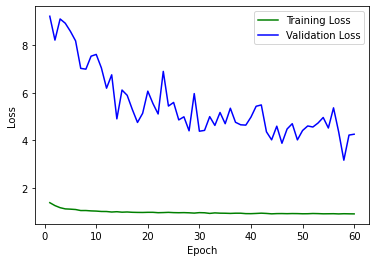

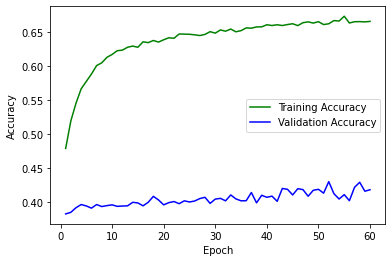

Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,13,9955,0,6,26
1,2,9721,0,7,270
2,2,9046,44,54,854
3,4,6154,12,357,3473
4,0,493,1,16,9490


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,0,400,0,0,0
1,0,399,0,0,1
2,0,382,0,0,18
3,0,289,0,0,111
4,0,13,0,0,387


Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,18,2429,0,3,0
1,2,1639,0,3,6
2,11,571,2,40,26
3,34,303,1,211,101
4,2,39,1,62,871


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,0,98,0,0,0
1,0,66,0,0,0
2,0,23,0,2,1
3,1,14,0,8,3
4,0,0,0,1,38


predictions file: predict_c2_h2_nFrnLAKTySysHV2ngdtruW.csv
1: 145
4: 55
Finished generating predictions to predict_c2_h2_nFrnLAKTySysHV2ngdtruW.csv


tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')

In [44]:
model = get_model(2048, 256, 0.5).to(device)
run_trial("h2", model)

#### H3: 512-64-5

* DNN Structure: 512-64-5
* Dropout: 0.5
* Class weights: [1,1,1,1,1]
* Batch normalization: no


In [ ]:
model = get_model(512, 64, 0.5).to(device)
run_trial("h3", model)

#### H4: Best from above, dropout 0.25

* DNN Structure: 
* Dropout: 0.25
* Class weights: [1,1,1,1,1]
* Batch normalization: no


In [ ]:
model = get_model(n1, n2, 0.25).to(device)
run_trial("h4", model)

#### H5: Best from above, dropout 0.1

* DNN Structure: 
* Dropout: 0.1
* Class weights: [1,1,1,1,1]
* Batch normalization: no


In [ ]:
model = get_model(n1, n2, 0.1).to(device)
run_trial("h5", model)

#### H6: Best from above, skewed class weights

* DNN Structure: 
* Dropout: 0.5
* Class weights: [1,1,5,5,1]
* Batch normalization: no


In [ ]:
model = get_model(n1, n2, 0.5).to(device)
run_trial("h6", model, class_weights=[1., 1., 5., 5., 1.])

#### H7: Best from above, batch normalization

* DNN Structure: 
* Dropout: 0.5
* Class weights: 
* Batch normalization: yes


In [ ]:
model = get_model(n1, n2, 0.5, batch_normalization=True).to(device)
run_trial("h7", model)

#### Summary: Best hyperparameters

In [ ]:
optimal_n1 = 1024
optimal_n2 = 128
optimal_d = 0.1


## Train with all C2 data and optimal hyperparameters

In [ ]:
model = get_model(optimal_n1, optimal_n2, optimal_d).to(device)
# model.load_state_dict(torch.load('cnn_pytorch_c2.pt'))
y_hat_test = train_and_test(model, group_3(), num_epochs=40)
predictions_file = "predict_c2_{}.csv".format(shortuuid.uuid())
print('predictions file:', predictions_file)
predict_whole_images(y_hat_test, PATCH_ROWS, PATCH_COLUMNS, predictions_file)

In [ ]:
torch.set_printoptions(profile="full")
print(y_hat_test)
torch.set_printoptions(profile="default")

### Save model

In [ ]:
torch.save(model.state_dict(), 'cnn_pytorch_c2.pt')